In [32]:
import pandas as pd
from ast import literal_eval
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from keras.layers import Masking, LSTM, Dense, Activation

In [52]:
df = pd.read_csv('music_embedding_3.tsv')
df['music_embedding'] = df['music_embedding'].apply(literal_eval)
df['genre_embedding'] = df['genre_embedding'].apply(literal_eval)
df.head(3)

,author_id,disorder,music_embedding,music_session,genre_embedding
0,1000026915590189062,control,"[1, -0.030979907140135765, 0.01254077535122633...",2,"[0, 0, 0, 1]"
1,1000123379356233729,control,"[1, 0.007308566011488438, -0.03472823277115822...",15,"[1, 0, 0, 0]"
2,1000123379356233729,control,"[1, -0.017335733398795128, 0.05415014922618866...",7,"[0, 0, 1, 0]"


In [53]:
print(len(df))
len(list(df.iloc[:1]["music_embedding"])[0])

75063


778

In [63]:
unique_genres = ["Pop", "Rock", "Hip Hop"]

new_genres = []
new_music_embeddings = []

for index, row in df.iterrows():
    
    genre_embedding = row['genre_embedding']
    genre_index = genre_embedding.index(1)

    if genre_index == 3:
        temp_new_genre = []
    elif genre_index == 0:
        temp_new_genre = [1, 0, 0]
    elif genre_index == 1:
        temp_new_genre = [0, 1, 0]
    else:
        temp_new_genre = [0, 0, 1]

    new_genres.append(temp_new_genre)

    
    new_music_embedding = row['music_embedding'][:769] + temp_new_genre + row['music_embedding'][773:]
    new_music_embeddings.append(new_music_embedding)

df['new_genre_embedding'] = new_genres
df['new_music_embedding'] = new_music_embeddings

df_filtered = df[~df['new_genre_embedding'].apply(lambda x: x == [])]
len(df_filtered)

59534

In [64]:
print(len(df_filtered))
len(list(df_filtered.iloc[:1]["new_music_embedding"])[0])

59534


777

In [65]:
max_sessions = 100

In [66]:
processed_users = 0

def prepare_sequences(data):
    
    global processed_users
    
    sequences = []
    labels = []
    
    for user_data in data.groupby('author_id'):
        
        user_df = user_data[1]
        
        if len(user_df) >= 5 :
            
            processed_users += 1
            
            user_dict = dict(user_df.iloc[0])
            
            temp_sequence = []
                
            count = 0
            
            for index, row in user_df.tail(max_sessions + 1).iterrows():
                
                if count == len(user_df) - 1 or count == max_sessions:
                    
                    labels.append(row["new_genre_embedding"])
                    
                else:
                    temp_sequence.append( row['new_music_embedding'])
                    count += 1
                
            sequences.append(temp_sequence)
        
    return sequences, labels

In [67]:
# Prepare sequences and labels
sequences, labels = prepare_sequences(df_filtered.copy())

for i, sequence in enumerate(sequences):
    if len(sequence) < max_sessions:
        padding_array = [0] * 777
        for j in range(0, (max_sessions - len(sequence))):
            sequences[i].append(padding_array)


labels = np.array(labels)
sequences = np.array(sequences)

In [68]:
print(labels.shape)
print(sequences.shape)


(2118, 3)
(2118, 100, 777)


In [69]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import compute_class_weight

early_stopper = EarlyStopping(monitor='val_loss',  
                              patience=10,  
                              verbose=1,
                              mode='min',
                              restore_best_weights=True)   


In [70]:
from keras.models import Model
import tensorflow as tf
from keras.layers import Layer
from tensorflow.keras.layers import Masking, GRU, Dense


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.dot(x, self.W) + self.b
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        context_vector = tf.reduce_sum(output, axis=1)
        return context_vector

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

Epoch 1/30
40/40 [==============================] - 21s 335ms/step - loss: 1.0184 - accuracy: 0.4882 - val_loss: 0.8907 - val_accuracy: 0.6061
Epoch 2/30
40/40 [==============================] - 10s 263ms/step - loss: 0.8665 - accuracy: 0.5882 - val_loss: 0.8561 - val_accuracy: 0.6014
Epoch 3/30
40/40 [==============================] - 11s 264ms/step - loss: 0.8074 - accuracy: 0.6409 - val_loss: 0.8662 - val_accuracy: 0.5613
Epoch 4/30
40/40 [==============================] - 10s 262ms/step - loss: 0.8024 - accuracy: 0.6394 - val_loss: 0.8868 - val_accuracy: 0.5920
Epoch 5/30
40/40 [==============================] - 11s 265ms/step - loss: 0.7961 - accuracy: 0.6465 - val_loss: 0.8524 - val_accuracy: 0.5943
Epoch 6/30
40/40 [==============================] - 11s 269ms/step - loss: 0.7652 - accuracy: 0.6575 - val_loss: 0.8841 - val_accuracy: 0.5731
Epoch 7/30
40/40 [==============================] - 11s 263ms/step - loss: 0.7614 - accuracy: 0.6811 - val_loss: 0.8970 - val_accuracy: 0.5825

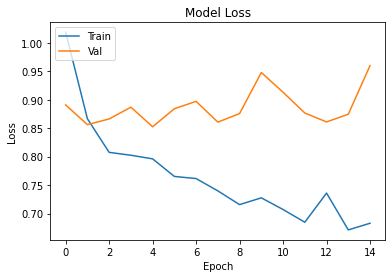

In [75]:
from keras.layers import Input, Masking, LSTM, Dense, AdditiveAttention
from keras.models import Model
import tensorflow as tf
from keras.layers import Layer
from keras.layers import Conv1D, MaxPooling1D

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 


X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)


batch_size = 32


model = Sequential()

model.add(Masking(mask_value=0., input_shape=(max_sessions, 777)))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))

# model.add(MaxPooling1D(pool_size=2))
          
model.add(LSTM(128, return_sequences=True, dropout=0.2))
model.add(LSTM(128, return_sequences=True, dropout=0.2))

model.add(AttentionLayer())

model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopper]) 


loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


/home/zeinab/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zeinab/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


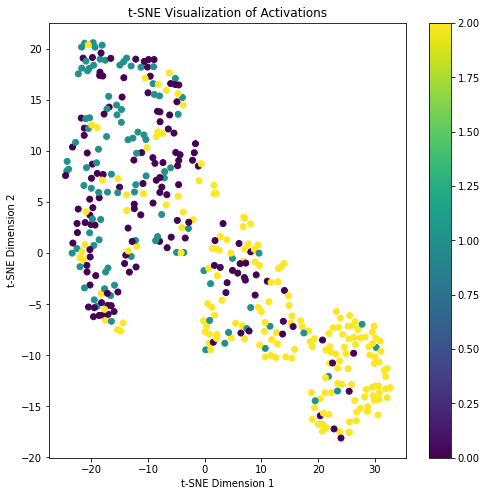

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output) 

# Extract activations for the validation set
activations_val = extractor.predict(X_val)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30)
activations_tsne = tsne.fit_transform(activations_val)

# Plot t-SNE embeddings
plt.figure(figsize=(8, 8))
plt.scatter(activations_tsne[:, 0], activations_tsne[:, 1], c=np.argmax(y_val, axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Activations')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [72]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)


f1_scores = f1_score(y_true_labels, y_pred_labels, average=None)



print("Confusion Matrix:")
print(conf_matrix)

print("F1 Score for Each Group:")
for i, genre in enumerate(unique_genres):
    print(f"{genre}: {f1_scores[i]}")


Confusion Matrix:
[[107  16  26]
 [ 66  28  17]
 [ 34   8 122]]
F1 Score for Each Group:
Pop: 0.601123595505618
Rock: 0.3435582822085889
Hip Hop: 0.7416413373860182


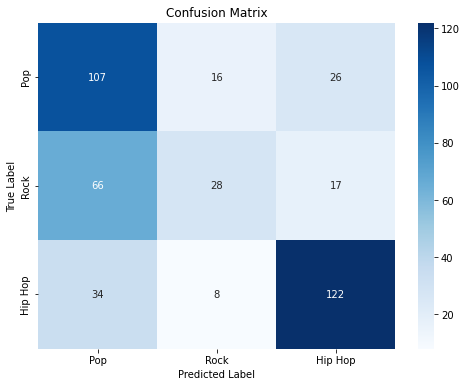

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_genres, yticklabels=unique_genres)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [27]:
print(len(y_test))


unique_genres = ["Pop", "Rock" ,"Hip Hop"]

genre_counts = {genre: 0 for genre in unique_genres}

list_y_test = list(y_test)

for row in list_y_test:
    
    row = list(row)
    
    genre_index = row.index(1)
    
    genre_counts[unique_genres[genre_index]] += 1

for genre, count in genre_counts.items():
    
    print(f"{genre}: {count}")

424
Pop: 149
Rock: 111
Hip Hop: 164


In [28]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_true_labels),
                                        y = y_true_labels                                                    
                                    )
class_weights_dict = dict(zip(np.unique(y_true_labels), class_weights))
print(class_weights_dict)

{0: 0.9485458612975392, 1: 1.2732732732732732, 2: 0.8617886178861789}
